In [1]:
%matplotlib inline

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import get_file
from tensorflow.keras.utils import plot_model

np.random.seed(10)
tf.random.set_seed(10)

## 데이터 가져오기

In [2]:
fpath = get_file("mnist_detection.npz",
                 "https://craftsangjae.s3.ap-northeast-2.amazonaws.com/data/mnist_detection.npz")
data = np.load(fpath)

train_images = data['train_images']
train_labels = data['train_labels']
test_images = data['test_images']
test_labels = data['test_labels']

## SSD 모델 불러오기

#### - Anchor 구성하기

In [3]:
class Anchors:
    """
    Anchor Configuration Class
    """
    bbox_df = pd.DataFrame()

    def __init__(self, strides, scales, ratios):
        self.strides = strides
        self.scales = scales
        self.ratios = ratios
        self.setup()

    def generate(self, image_shape):
        """
        image_shape에 맞춰서, Anchor(==Default Boxes)를 구성

        return :
        (# Anchors, 4)로 이루어진 출력값 생성
        """
        height, width = image_shape[:2]
        multi_boxes = []
        for stride, df in self.bbox_df.groupby('stride'):
            boxes = []
            for idx, row in df.iterrows():
                stride, box_width, box_height = row.stride, row.w, row.h
                ys, xs = np.mgrid[0:height:stride, 0:width:stride]
                box_width = np.ones_like(xs) * box_width
                box_height = np.ones_like(ys) * box_height
                center_xs = stride // 2 + xs
                center_ys = stride // 2 + ys

                block_centers = np.stack((center_xs, center_ys,
                                          box_width, box_height),
                                         axis=-1)
                boxes.append(block_centers)
            boxes = np.stack(boxes, axis=2)
            boxes = np.reshape(boxes, (-1, 4))
            multi_boxes.append(boxes)
        multi_boxes = np.concatenate(multi_boxes, axis=0)
        return multi_boxes

    def setup(self):
        bbox_df = pd.DataFrame(columns=['stride', 'w', 'h'])
        for scale, stride in zip(self.scales, self.strides):
            for ratio in self.ratios:
                w = np.round(scale * ratio[0]).astype(np.int)
                h = np.round(scale * ratio[1]).astype(np.int)
                bbox_df.loc[len(bbox_df) + 1] = [stride, w, h]

        bbox_df.stride = bbox_df.stride.astype(np.int)
        bbox_df.w = bbox_df.w.astype(np.int)
        bbox_df.h = bbox_df.h.astype(np.int)
        self.bbox_df = bbox_df

In [4]:
strides = [4, 8, 16]
scales = [10, 20, 30]
ratios = [(1,1),     # ratio : 1.
          (0.5,1.5), # ratio : 0.33
          (0.8,1.2), # ratio : 0.67
          (1.2,0.8), # ratio : 1.5
          (1.4,1.4)  # ratio : 1
         ] 

anchors = Anchors(strides, scales, ratios)

#### - Custom Object 가져오기

In [5]:
def SSDLoss(alpha=1., pos_neg_ratio=3.):
    def ssd_loss(y_true, y_pred):
        num_classes = tf.shape(y_true)[2] - 4
        y_true = tf.reshape(y_true, [-1, num_classes + 4])
        y_pred = tf.reshape(y_pred, [-1, num_classes + 4])
        eps = K.epsilon()

        # Split Classification and Localization output
        y_true_clf, y_true_loc = tf.split(y_true, 
                                          [num_classes, 4], 
                                          axis=-1)
        y_pred_clf, y_pred_loc = tf.split(y_pred, 
                                          [num_classes, 4], 
                                          axis=-1)

        # split foreground & background
        neg_mask = y_true_clf[:, -1]
        pos_mask = 1 - neg_mask
        num_pos = tf.reduce_sum(pos_mask)
        num_neg = tf.reduce_sum(neg_mask)
        num_neg = tf.minimum(pos_neg_ratio * num_pos, num_neg)

        # softmax loss
        y_pred_clf = K.clip(y_pred_clf, eps, 1. - eps)
        clf_loss = -tf.reduce_sum(y_true_clf * tf.math.log(y_pred_clf),
                                  axis=-1)
        pos_clf_loss = tf.reduce_sum(clf_loss * pos_mask) / (num_pos + eps)
        neg_clf_loss = clf_loss * neg_mask
        values, indices = tf.nn.top_k(neg_clf_loss,
                                      k=tf.cast(num_neg, tf.int32))
        neg_clf_loss = tf.reduce_sum(values) / (num_neg + eps)
        clf_loss = pos_clf_loss + neg_clf_loss
        
        # smooth l1 loss
        l1_loss = tf.math.abs(y_true_loc - y_pred_loc)
        l2_loss = 0.5 * (y_true_loc - y_pred_loc) ** 2
        loc_loss = tf.where(tf.less(l1_loss, 1.0),
                            l2_loss,
                            l1_loss - 0.5)
        loc_loss = tf.reduce_sum(loc_loss, axis=-1)
        loc_loss = tf.reduce_sum(loc_loss * pos_mask) / (num_pos + eps)

        # total loss
        return clf_loss + alpha * loc_loss
    return ssd_loss

#### - 모델 불러오기

In [12]:
from tensorflow.keras.models import load_model

model = load_model("./file.h5", custom_objects={'ssd_loss':SSDLoss(1.0,3.)})

### 모델 추론하기

#### - 출력값을 predicted Bounding Box로 변경하기

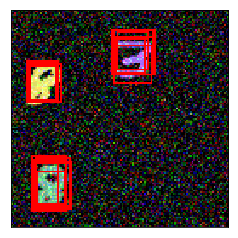

In [13]:
images = test_images[:1].copy() # 이미지를 가져오기
X = images / 255.
predictions = model.predict(X)

idx=0
pred_loc = predictions[idx,:,-4:]
pred_clf = predictions[idx,:,:-4]
pr_boxes = anchors.generate(images[0].shape)

# 원래의 bounding box로 복원하기
res_cx = (pred_loc[:,0] 
          * pr_boxes[:,2] 
          + pr_boxes[:,0])
res_cy = (pred_loc[:,1] 
          * pr_boxes[:,3] 
          + pr_boxes[:,1])
res_w = (np.exp(pred_loc[:,2])
         *pr_boxes[:,2])
res_h = (np.exp(pred_loc[:,3])
         *pr_boxes[:,3])

restore_boxes = np.stack([res_cx,res_cy,res_w,res_h],
                         axis=-1)

# Background를 제외
bg_index = pred_clf.shape[-1]-1
fg_indices = np.argwhere(pred_clf.argmax(axis=1)!=bg_index)
restore_boxes = restore_boxes[fg_indices].squeeze()

pred_clf = pred_clf[fg_indices]
pred_clf = pred_clf.max(axis=-1)
pred_clf = pred_clf.squeeze()

vis = images[idx].copy()
for boxes in restore_boxes:
    cx, cy, w, h = boxes.astype(np.int)
    cv2.rectangle(vis, (cx-w//2,cy-h//2),(cx+w//2,cy+h//2), (255,0,0))
    
plt.imshow(vis)
plt.xticks([])
plt.yticks([])    
plt.show()        

위의 경우 너무나 겹치는 이미지들이 많습니다. 이를 어떻게 효과적으로 겹치는 것들을 지울 수 있을까요? 바로 그 알고리즘이 `Non-Maximum Suppression` 입니다.

#### - Non-Maximum Suppression 적용하기

Non-Maximum Suppression의 알고리즘은 심플합니다. 하나씩 박스를 꺼내서 해당 박스와 특정값 이상(예 50% 이상) 겹치면 제거해주는 알고리즘입니다. 

![Imgur](https://i.imgur.com/NsppxPr.png)

In [14]:
def non_maximum_suppression(boxes, confs, overlap_threshold=0.3):
    pick = []
    cx, cy, w, h = boxes.T
    x1, x2 = cx - w/2, cx + w/2
    y1, y2 = cy - h/2, cy + h/2    
    
    indices = np.argsort(confs)[::-1]
    area = (x2 - x1) * (y2 - y1)
    
    while len(indices) > 0:
        idx, indices = indices[0], indices[1:]
        pick.append(idx)

        xx1 = np.maximum(x1[idx], x1[indices])
        yy1 = np.maximum(y1[idx], y1[indices])
        xx2 = np.minimum(x2[idx], x2[indices])
        yy2 = np.minimum(y2[idx], y2[indices])
        
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        intersection = w * h
        union = area[indices] + area[idx] - intersection
        overlap = intersection/(union+1e-8)
        
        indices = indices[overlap <= overlap_threshold]
    return pick

In [21]:
def draw_rectangle(image, boxes):
    vis = image.copy()
    for box in boxes:
        cx, cy, w, h = box.astype(np.int)
        cv2.rectangle(vis, (cx-w//2,cy-h//2),(cx+w//2,cy+h//2), (255,0,0))
    return vis

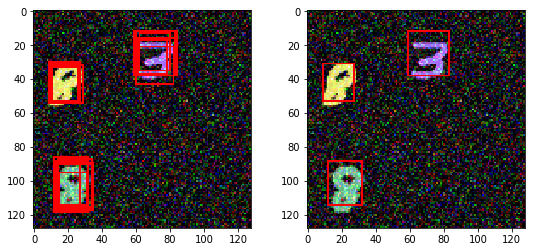

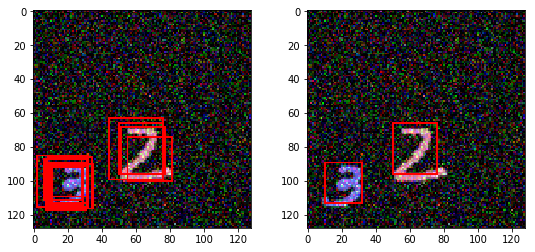

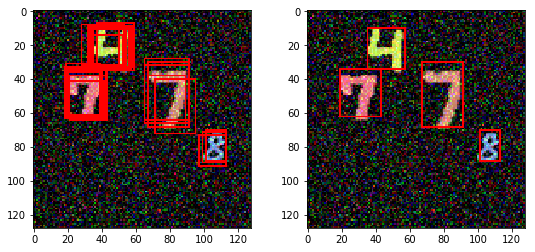

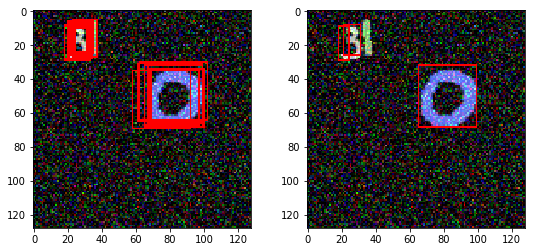

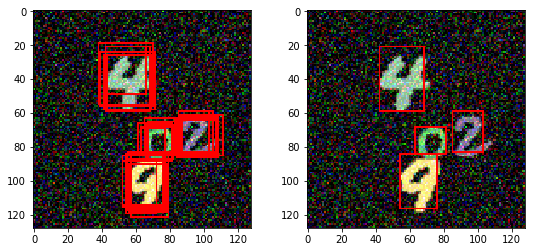

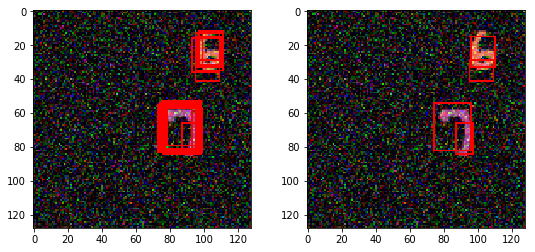

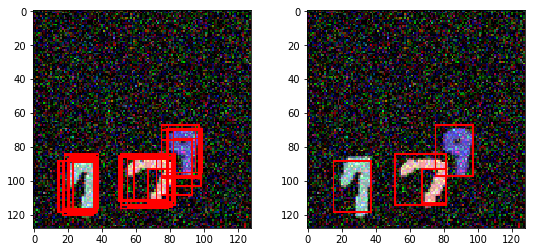

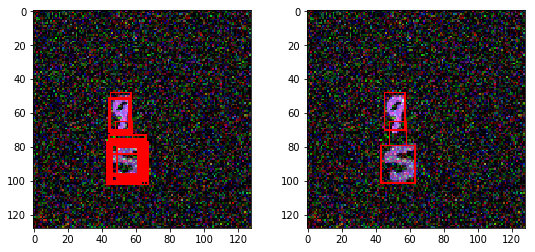

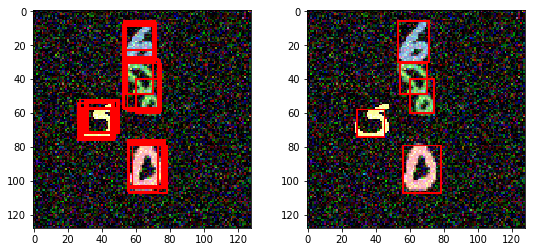

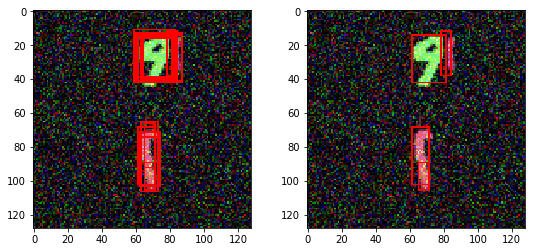

In [22]:
images = test_images[:10].copy()
X = images / 255.
predictions = model.predict(X)

for idx, image in enumerate(images[:20]):
    pred_loc = predictions[idx,:,-4:]
    pred_clf = predictions[idx,:,:-4]
    pr_boxes = anchors.generate(images[0].shape)

    # 예측값을 bounding Box 값(cx,cy,w,h)으로 복원하기
    res_cx = (pred_loc[:,0] 
              * pr_boxes[:,2] 
              + pr_boxes[:,0])
    res_cy = (pred_loc[:,1] 
              * pr_boxes[:,3] 
              + pr_boxes[:,1])
    res_w = (np.exp(pred_loc[:,2])
             *pr_boxes[:,2])
    res_h = (np.exp(pred_loc[:,3])
             *pr_boxes[:,3])
    restore_boxes = np.stack([res_cx,res_cy,res_w,res_h],
                             axis=-1)
    
    bg_index = pred_clf.shape[-1]-1
    fg_indices = np.argwhere(pred_clf.argmax(axis=1)!=bg_index)
    
    restore_boxes = restore_boxes[fg_indices].squeeze()
    pred_clf = pred_clf[fg_indices]
    pred_scores = pred_clf.max(axis=-1)
    pred_scores = pred_scores.squeeze()
    
    # NMS 적용
    pick_indices = non_maximum_suppression(restore_boxes, 
                                           pred_scores,
                                           0.5)
    chosen_boxes = restore_boxes[pick_indices]
    
    before_nms = draw_rectangle(images[idx], restore_boxes)    
    after_nms = draw_rectangle(images[idx], chosen_boxes)
    fig = plt.figure(figsize=(9,4))
    ax = fig.add_subplot(1,2,1)
    ax.imshow(before_nms)
    ax = fig.add_subplot(1,2,2)
    ax.imshow(after_nms)
    plt.show()
    